## Calibration of Gaussian-Schell model beam

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields
from numpy.fft import fft, ifft, fftshift, ifftshift

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


I am simulating a Gaussian Schell model beam using a technique described in [Xiao and Voelz, "Wave optics simulation approach for partial spatially coherent beams," Opt. Express 14, 6986-6992 (2006)](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986).

## Build the coordinate system

In [8]:
focalLength = 250000 # microns

wavelength  = 0.650 # microns

gridSize     = 10001 # Number of grid (or lattice) sites for a single lenslet
physicalSize = 50000 # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.Grid(gridSize, physicalSize, wavelength, focalLength, dim = 1)

The desired coherence length is set in `coherenceLength`. The rest of the beam is defined as described in another notebook.

In [9]:
Z0              = 376.73 # Impedance of free space, Ohms
power           = 100  # mW
beamStd         = 1000 # microns
coherenceLength = 8000 # microns
fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W

beam     = fields.GSMBeamRealization(fieldAmp, beamStd, coherenceLength, grid)

Let's go ahead and plot one realization of the phase angle generated from this beam. We won't use the Gaussian envelope; only the phase.

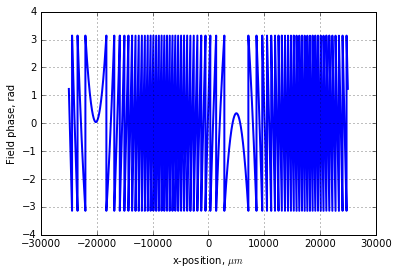

In [11]:
beamSample = beam(grid.px)

plt.plot(grid.px, np.angle(beamSample), linewidth = 2)
plt.xlabel(r'x-position, $\mu m$')
plt.ylabel(r'Field phase, rad')
plt.grid(True)
plt.show()

## Computing the two-slit diffraction pattern
First, let's define the field. We have a plane wave incident on two slits symmetrically placed about the origin.

In [12]:
slitWidth  = 2000 # microns
slitOffset = 2500 # microns
beamPower  = 100  # mW

Z0      = 376.73 # Impedance of free space, Ohms
amp   = np.sqrt((beamPower / 1000) * Z0 / 2 * slitWidth)
field = np.zeros(grid.px.size)
field[np.logical_and(grid.px >  (-slitOffset - slitWidth / 2), grid.px <= (-slitOffset + slitWidth / 2))] = amp
field[np.logical_and(grid.px >= ( slitOffset - slitWidth / 2), grid.px <  ( slitOffset + slitWidth / 2))] = amp

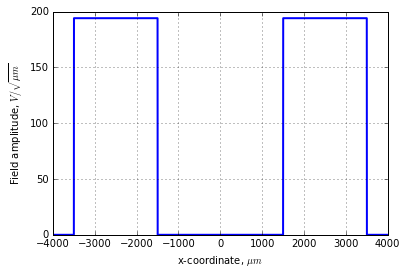

In [13]:
plt.plot(grid.px, field, linewidth = 2)
plt.xlim((-4000, 4000))
plt.xlabel(r'x-coordinate, $\mu m$')
plt.ylabel(r'Field amplitude, $V / \sqrt{\mu m}$')
plt.grid(True)
plt.show()

Next, let's compute the diffraction pattern from this field distribution.

In [14]:
dx = grid.px[1] - grid.px[0]
F  = fftshift(fft(ifftshift(field))) * dx
Irrad = np.abs(F)**2 / wavelength / focalLength

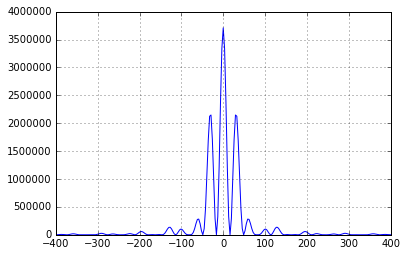

In [15]:
plt.plot(grid.pX, Irrad)
plt.xlim((-400,400))
plt.grid(True)
plt.show()

## Add partial spatial coherence to the incident beam.
Now that we have a two slit interferometer to experiment with, we can begin adjust the spatial coherence of the beam.

Let's first start by computing the random realization of the phase screen and apply it to the incident field.

In [16]:
# beamSample was generated earlier
t = np.exp(1j * np.angle(beamSample))

newField = t * field

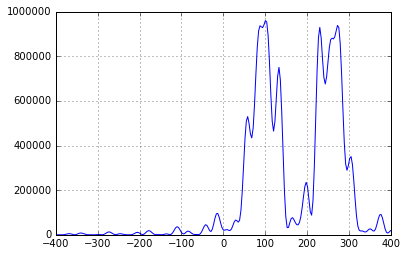

In [17]:
# Propagate and plot the new field
dx = grid.px[1] - grid.px[0]
F  = fftshift(fft(ifftshift(newField))) * dx
Irrad = np.abs(F)**2 / wavelength / focalLength

plt.plot(grid.pX, Irrad)
plt.xlim((-400,400))
plt.grid(True)
plt.show()

Now we see that after one realization, the fringe modulation is not as strong. Specifically, the null fringes near the origin are no longer exactly zero.

## Compute the averaged irradiance for multiple realizations

In [11]:
nIter = 100
dx = grid.px[1] - grid.px[0]

finalIrrad = np.zeros(grid.px.size)
for ctr in range(nIter):
    # Create a new realization of the field
    t = np.exp(1j * np.angle(beam(grid.px)))
    newField = t * field
    
    F  = fftshift(fft(ifftshift(newField))) * dx
    Irrad = np.abs(F)**2 / wavelength / focalLength
    
    finalIrrad = finalIrrad + Irrad
    
# Find the averaged irradiance pattern    
finalIrrad = finalIrrad / nIter

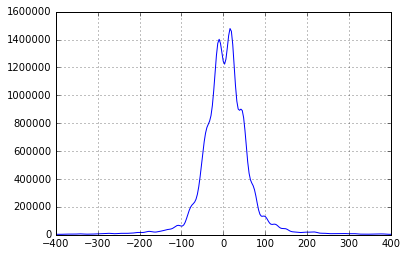

In [12]:
plt.plot(grid.pX, finalIrrad)
plt.xlim((-400,400))
plt.grid(True)
plt.show()

In [13]:
grid.pfX

array([-0.02   , -0.01998, -0.01996, ...,  0.01996,  0.01998,  0.02   ])

In [14]:
dx

25.0

In [15]:
df = 1 / 25 / 2000

In [16]:
df

2e-05

In [24]:
grid.pfX[1] - grid.pfX[0]

1.9999999999999185e-05

In [21]:
1 / physicalSize

2e-05